# Install Librairies

In [1]:
!pip install azure
!pip uninstall azure-storage-blob
!pip install azure-storage-blob
!pip install azurebatchload
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 167 kB 7.5 MB/s 
     |████████████████████████████████| 1.1 MB 58.8 MB/s 
     |████████████████████████████████| 314 kB 67.3 MB/s 
     |████████████████████████████████| 352 kB 52.9 MB/s 
     |████████████████████████████████| 75 kB 5.2 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
     |████████████████████████████████| 61 kB 358 kB/s 
     |████████████████████████████████| 103 kB 56.3 MB/s 
     |████████████████████████████████| 75 kB 4.5 MB/s 
     |████████████████████████████████| 125 kB 68.6 MB/s 
     |████████████████████████████████| 85 kB 5.3 MB/s 
     |████████████████████████████████| 40 kB 6.1 MB/s 
     |████████████████████████████████| 4.0 MB 40.7 MB/s 
     |████████████████████████████████| 55 kB 4.1 MB/s 
     |████████████████████████████████| 185 kB 51.6 MB/s 
     |████████████████████████████████| 88 kB 

# Load Librairies

In [2]:
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient

from tensorflow.keras.applications.inception_v3 import InceptionV3

# importing all from pyspark.sql.function
from pyspark.sql.functions import *

from pyspark.sql.types import StringType, IntegerType
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
import pandas as pd

# Start Spark Session

In [6]:
spark = SparkSession.builder\
        .appName('Déployez un modèle dans le cloud')\
        .getOrCreate()

# Connexion Azure blob storage

In [ ]:
connect_str = "DefaultEndpointsProtocol=https;AccountName=databricksfruitssa;AccountKey=C2yq8BgU54JI7K+GNneZ6UN5QQy1KfZF80CX1b4C70Md1s8JQ8SdCv6wnDJsXbtgX7QpGmZxPQup+ASt1fEwQw==;EndpointSuffix=core.windows.net"

blob_service_client = BlobServiceClient.from_connection_string(connect_str)

container_name="fruits"
container_client=blob_service_client.get_container_client(container_name)

blob_list = container_client.list_blobs(name_starts_with="Training/")

# Création dataset

In [ ]:
blobs = [item.name for item in blob_list]
#blobs

In [ ]:
columns = ['blobs']
df = spark.createDataFrame(blobs, StringType(), ['blobs'])
df.show(truncate=False)

+---------------------------+
|value                      |
+---------------------------+
|Training/apple_6/r0_10.jpg |
|Training/apple_6/r0_100.jpg|
|Training/apple_6/r0_102.jpg|
|Training/apple_6/r0_104.jpg|
|Training/apple_6/r0_106.jpg|
|Training/apple_6/r0_108.jpg|
|Training/apple_6/r0_110.jpg|
|Training/apple_6/r0_112.jpg|
|Training/apple_6/r0_114.jpg|
|Training/apple_6/r0_116.jpg|
|Training/apple_6/r0_118.jpg|
|Training/apple_6/r0_12.jpg |
|Training/apple_6/r0_120.jpg|
|Training/apple_6/r0_122.jpg|
|Training/apple_6/r0_124.jpg|
|Training/apple_6/r0_126.jpg|
|Training/apple_6/r0_128.jpg|
|Training/apple_6/r0_130.jpg|
|Training/apple_6/r0_132.jpg|
|Training/apple_6/r0_134.jpg|
+---------------------------+
only showing top 20 rows



In [ ]:
# split() function defining parameters
split_cols = split(df['value'], '/')
  
# Now applying split() using withColumn()
image_df = df.withColumn('label', split_cols.getItem(1))

image_df = image_df.withColumnRenamed('value', 'path')

image_df.show(truncate=False)


+---------------------------+-------+
|path                       |label  |
+---------------------------+-------+
|Training/apple_6/r0_10.jpg |apple_6|
|Training/apple_6/r0_100.jpg|apple_6|
|Training/apple_6/r0_102.jpg|apple_6|
|Training/apple_6/r0_104.jpg|apple_6|
|Training/apple_6/r0_106.jpg|apple_6|
|Training/apple_6/r0_108.jpg|apple_6|
|Training/apple_6/r0_110.jpg|apple_6|
|Training/apple_6/r0_112.jpg|apple_6|
|Training/apple_6/r0_114.jpg|apple_6|
|Training/apple_6/r0_116.jpg|apple_6|
|Training/apple_6/r0_118.jpg|apple_6|
|Training/apple_6/r0_12.jpg |apple_6|
|Training/apple_6/r0_120.jpg|apple_6|
|Training/apple_6/r0_122.jpg|apple_6|
|Training/apple_6/r0_124.jpg|apple_6|
|Training/apple_6/r0_126.jpg|apple_6|
|Training/apple_6/r0_128.jpg|apple_6|
|Training/apple_6/r0_130.jpg|apple_6|
|Training/apple_6/r0_132.jpg|apple_6|
|Training/apple_6/r0_134.jpg|apple_6|
+---------------------------+-------+
only showing top 20 rows



In [ ]:
image_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)



In [ ]:
# On va utiliser un StringIndexer pour encoder nos labels
stringIndexer = StringIndexer(inputCol='label', outputCol='label_encoded')
sI = stringIndexer.fit(image_df)

# On encode et on convertit nos labels en Integer (lisibilité)
image_df = sI.transform(image_df)
image_df = image_df.withColumn('label_encoded', col('label_encoded').cast(IntegerType()))

# On réorganise nos colonnes (lisibilité)
image_df = image_df.select('path', 'label', 'label_encoded')
image_df.show(5)

+--------------------+-------+-------------+
|                path|  label|label_encoded|
+--------------------+-------+-------------+
|Training/apple_6/...|apple_6|            8|
|Training/apple_6/...|apple_6|            8|
|Training/apple_6/...|apple_6|            8|
|Training/apple_6/...|apple_6|            8|
|Training/apple_6/...|apple_6|            8|
+--------------------+-------+-------------+
only showing top 5 rows



# Connexion sur google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
spark

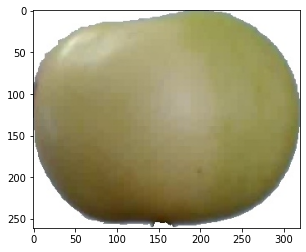

In [42]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("/content/drive/MyDrive/openclassroom/Déployez_un_modèle_dans_le_cloud_sooprayen_oorvasi/Images/Training/apple_6/r0_0.jpg")
img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

In [40]:
import os
inside = os.listdir('/content/drive/MyDrive/openclassroom/Déployez_un_modèle_dans_le_cloud_sooprayen_oorvasi/Images/Training/')
for i in range(20):
  print(inside[i])

apple_red_yellow_1
apple_braeburn_1
apple_golden_3
apple_hit_1
pear_1
apple_granny_smith_1
apple_golden_1
apple_crimson_snow_1
apple_6
.DS_Store
apple_red_delicios_1
eggplant_violet_1
zucchini_1
apple_golden_2
apple_rotten_1
cucumber_3
pear_3
cucumber_1
apple_pink_lady_1
carrot_1


## Load images via spark

In [43]:
data_train_path='/content/drive/MyDrive/openclassroom/Déployez_un_modèle_dans_le_cloud_sooprayen_oorvasi/Images/Training/**/*.jpg'
df_train = spark.read.format('image').load(data_train_path, inferschema=True)
df_train.count()

6319

In [47]:
df_train.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [48]:
df_train.show()

+--------------------+
|               image|
+--------------------+
|{file:/content/dr...|
|{file:/content/dr...|
|{file:/content/dr...|
|{file:/content/dr...|
|{file:/content/dr...|
|{file:/content/dr...|
|{file:/content/dr...|
|{file:/content/dr...|
|{file:/content/dr...|
|{file:/content/dr...|
|{file:/content/dr...|
|{file:/content/dr...|
|{file:/content/dr...|
|{file:/content/dr...|
|{file:/content/dr...|
|{file:/content/dr...|
|{file:/content/dr...|
|{file:/content/dr...|
|{file:/content/dr...|
|{file:/content/dr...|
+--------------------+
only showing top 20 rows



In [68]:
df_train['image']

Column<'image'>

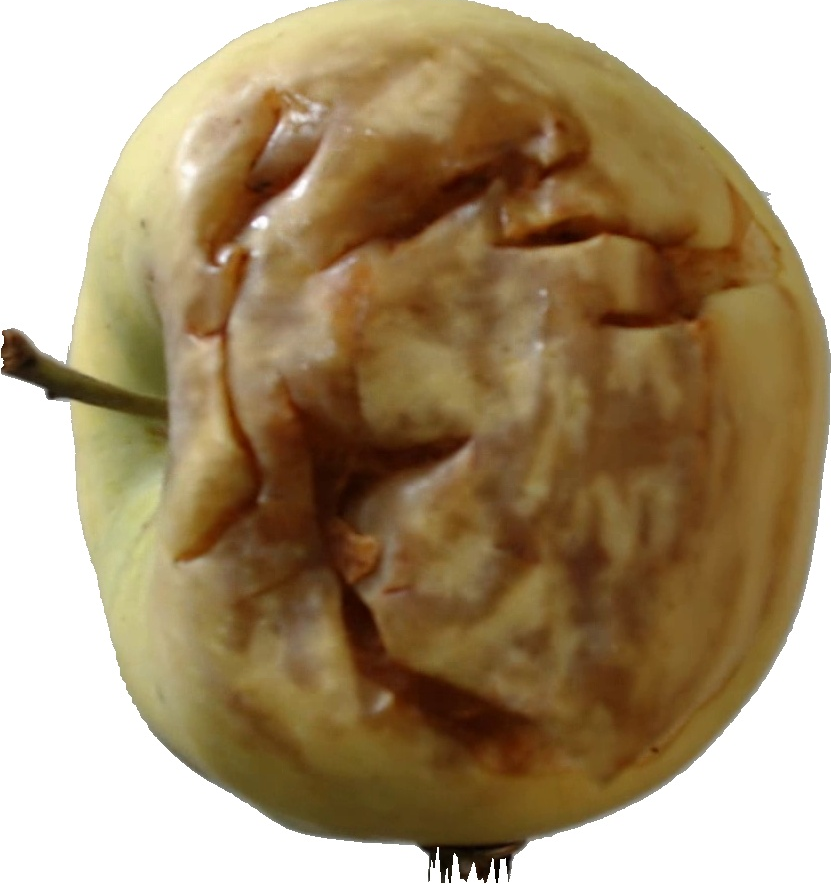

In [58]:
from pyspark.ml.image import ImageSchema
from PIL import Image

# Affichage d'une image
ImageArray_first = ImageSchema.toNDArray(df_train.first()['image'])[6:, :, ::-1]
Image.fromarray(ImageArray_first)

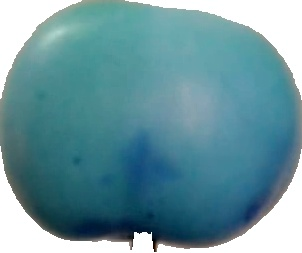

In [85]:
data = df_train.tail(50)    # take rows of the dataframe
im = data[30][0]         # the image is in the first column of a given row

arr = ImageSchema.toNDArray(im)     # convert to numpy array
Image.fromarray(arr, "RGB")   # display the image inside notebook